In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.datasets import fetch_openml

def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
sort_by_target(mnist) # fetch_openml() returns an unsorted dataset

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
X, y = mnist['data'], mnist['target']
print("X shape: {} \t y shape: {}".format(X.shape, y.shape))

X shape: (70000, 784) 	 y shape: (70000,)


(-0.5, 27.5, 27.5, -0.5)

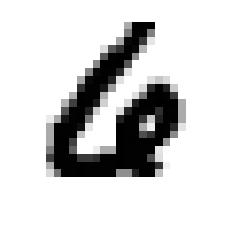

In [26]:
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[40000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, 
          interpolation='nearest')
plt.axis('off')

In [25]:
y[40000]

6

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [7]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### Training Binary Classifier

Classifier to detect if number is 6 or not i.e. number 6-detector

In [8]:
y_train_6 = (y_train == 6)
y_test_6 = (y_test == 6)

array([False, False, False, ..., False, False, False])

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_6)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [10]:
sgd_clf.predict([some_digit])

array([False])

### Performance Measures
#### Measuring accuracy using Cross-Validation

In [11]:
from sklearn.model_selection import StratifiedKFold # performs stratified sampling to produce folds
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_6):
    # Each iteration creates a clone of classifier
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_6[train_index])
    X_test_folds = X_train[test_index]
    y_test_folds = (y_train_6[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds) # Training each clone on training folds
    y_pred = clone_clf.predict(X_test_folds)    # Predictions for testing fold
    n_correct = sum(y_pred == y_test_folds)     # No of correct predictions
    print(n_correct / len(y_pred))              # Ratio of correct predictions

0.9797510124493776
0.9795
0.9827991399569979


In [12]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_6, cv=3, scoring='accuracy')

array([0.97975101, 0.9795    , 0.98279914])

We can observe accuracy of more than 97%

Classifier to classify every number which is in 'Not-6' class:

In [13]:
from sklearn.base import BaseEstimator

class Never6Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_6_clf = Never6Classifier()
cross_val_score(never_6_clf, X_train, y_train_6, cv=3, scoring='accuracy')

array([0.90045, 0.90295, 0.9007 ])

We can notice how even a dumb class predicted with 90% accuracy. This is because only about 10% of the images are of 6, so if you always guess false, you will be right 90% of the time. This shows skewness of data ie some classes are more frequent than others

### Confusion Matrix
The general idea is to count no. of times class A has been classified as class B

In [14]:
from sklearn.model_selection import cross_val_predict # similar to cross_val_scores but returns predictions instead of scores
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_6, cv=3)
confusion_matrix(y_train_6, y_train_pred)

array([[53419,   663],
       [  496,  5422]], dtype=int64)

---
#### Note: 
[[r1c1, r1c2],
 [r2c1, r2c2]]
 
Here rows represent actual values ie 
- r1: non 6 images
- r2: 6 images
                                      
And columns represent predicted values ie 
- c1: non 6 images
- c2: 6 images

This means 
- r1c1 is no. of correct predictions for non 6 images
- r1c1 is no. of incorrect predictions for non 6 images
- r1c1 is no. of incorrect predictions for 6 images
- r1c1 is no. of correct predictions for 6 images

---

In [15]:
y_train_perfect_preds = y_train_6
confusion_matrix(y_train_6, y_train_perfect_preds)

array([[54082,     0],
       [    0,  5918]], dtype=int64)

---
### Recall and Precision

In [16]:
from sklearn.metrics import precision_score, recall_score

print("Precision score: ", precision_score(y_train_6, y_train_pred)) 
print("Recall score: ", recall_score(y_train_6, y_train_pred))

Precision score:  0.8910435497124075
Recall score:  0.9161879013180129


---
Precision score represents that prediction of image 6 is right for 89% of times ie if 100 images of various numbers are identified as 6 than only 89 of them are actually images of 6.

Recall score represents about 91% of images of 6 are identified correctly ie. out of 100 images of 6 only 91 are identified as 6 rest are not

---

In [19]:
from sklearn.metrics import f1_score

f1_score(y_train_6, y_train_pred) # f1 favours classifier with similar precision and recall score

0.9034408064650504

In [29]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([123669.15050055])

In [30]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [31]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

This confirms that raising the threshold decreases recall.

In [35]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_6, cv=3, method="decision_function")

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_6, y_scores)

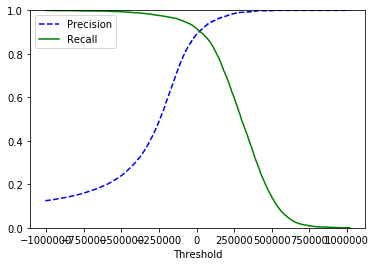

In [36]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)